## Import packages

In [1]:
import torch
from sciPENN.Preprocessing import preprocess
torch.cuda.is_available()

True

In [2]:
%load_ext autoreload
%autoreload 2

import os

import sys
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import scanpy as sc
sc.set_figure_params(dpi=100, dpi_save=300)
import scvi
import anndata as ad
from matplotlib import pyplot, cm
import os
from math import ceil
from scipy.stats import spearmanr
import math

import leidenalg

from anndata import AnnData
from scanpy import read
import pandas as pd
from scipy.sparse import csc_matrix


import matplotlib.pyplot as plt

# Read data: 

In [3]:
adata_covid19 = sc.read_h5ad("../Data/immunodeficiency_covid_PMBCs.h5ad")

In [4]:
back_to_counts = np.round(2**adata_covid19.X.toarray().astype('float32') - 1)
adata_covid19.X = csc_matrix(back_to_counts)
back_to_counts = None

In [5]:
adata_gene_test = adata_covid19[:, adata_covid19.var["feature_types"] == "Gene Expression"].copy()
adata_protein_test = adata_covid19[:, adata_covid19.var["feature_types"] == "Antibody Capture"].copy()
adata_covid19 = None

In [6]:
adata_covid19 = sc.read_h5ad('../Data/Covid_Combined_SCE_raw.h5ad')

In [7]:
adata_covid19.X = adata_covid19.X.astype('float32')
adata_gene_train = adata_covid19[:, adata_covid19.var["feature_types"] == "Gene Expression"].copy()
adata_protein_train = adata_covid19[:, adata_covid19.var["feature_types"] == "Antibody Capture"].copy()
adata_covid19 = None

In [8]:
adata_protein_train.var.index = [x[3:] for x in adata_protein_train.var.index]
adata_protein_test.var.index = [x[3:] for x in adata_protein_test.var.index]

In [9]:
imputed_match, train_names = pd.read_csv("../Data/matched_proteins.csv", header = None).to_numpy().T

mapping = {key: value for key, value in zip(train_names, imputed_match)}

tmp = adata_protein_test.var.index.values

for i in range(len(tmp)):
    if tmp[i] in mapping:
        tmp[i] = mapping[tmp[i]]
        
adata_protein_test.var.index = tmp

In [10]:
train_proteins = adata_protein_train.var.index
test_proteins = adata_protein_test.var.index

all_proteins = np.intersect1d(train_proteins, test_proteins)
all_proteins

array(['B7-H4', 'BAFF', 'BAFFR', 'BTLA', 'CCR3', 'CCR4', 'CCR5', 'CCR6',
       'CCR7', 'CD101', 'CD123', 'CD14', 'CD141', 'CD15', 'CD158',
       'CD158b', 'CD16', 'CD161', 'CD163', 'CD19', 'CD1C', 'CD1a', 'CD1d',
       'CD2', 'CD20', 'CD209', 'CD21', 'CD22', 'CD226', 'CD235ab', 'CD24',
       'CD244', 'CD25', 'CD27', 'CD274', 'CD28', 'CD3', 'CD303', 'CD304',
       'CD33', 'CD34', 'CD36', 'CD38', 'CD4', 'CD40', 'CD44', 'CD45',
       'CD45RA', 'CD45RO', 'CD47', 'CD5', 'CD52', 'CD56', 'CD58', 'CD62L',
       'CD64', 'CD69', 'CD7', 'CD70', 'CD71', 'CD79b', 'CD8', 'CD80',
       'CD81', 'CD82', 'CD83', 'CD86', 'CD96', 'CD99', 'CLEC12A',
       'CLEC9A', 'CTLA4', 'CX3CR1', 'CXCR3', 'CXCR4', 'CXCR5', 'DR3',
       'FAS', 'FCRL4', 'FCRL5', 'FcERIa', 'HLA-ABC', 'HLA-A_2', 'HLA-DR',
       'HLA-F', 'IL2RB', 'IL4R', 'IL7R', 'IgA', 'IgD', 'IgM', 'KIR2DL5A',
       'KIR3DL1', 'LAG3', 'LAMP1', 'Mouse IgG1_K_Iso',
       'Mouse_IgG2a_K_Iso', 'Mouse_IgG2b_K_Iso', 'NECTIN2', 'NLRP2',
       'PD1',

In [11]:
np.random.seed(123)
common = np.random.choice(all_proteins, len(all_proteins)//3, False)
proteins2 = np.setdiff1d(all_proteins, common)
proteins1 = np.random.choice(proteins2, len(proteins2)//2, False)
proteins2 = np.setdiff1d(proteins2, proteins1)

testset1_truth_ = adata_protein_train[:, proteins2].copy()
testset2_truth_ = adata_protein_test[:, proteins1].copy()

adata_protein_train = adata_protein_train[:, list(proteins1) + list(common)].copy()
adata_protein_test = adata_protein_test[:, list(common) + list(proteins2)].copy()

# Processing Data

In [13]:
gene_train, protein_train, gene_test, bools, train_keys, categories = preprocess([adata_gene_train], [adata_protein_train], adata_gene_test, train_batchkeys = ["sample_id"], test_batchkey = "Donor Id", gene_list = [], select_hvg = True, cell_normalize = True, log_normalize = True, gene_normalize = True, min_cells = 30, min_genes = 200)


QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,
... storing 'sample_id' as categorical
... storing 'full_clustering' as categorical
... storing 'initial_clustering' as categorical
... storing 'Resample' as categorical
... storing 'Collection_Day' as categorical
... storing 'Sex' as categorical
... storing 'Age_interval' as categorical
... storing 'Swab_result' as categorical
... storing 'Status' as categorical
... storing 'Smoker' as categorical
... storing 'Status_on_day_collection' as categorical
... storing 'Status_on_day_collection_summary' as categorical
... storing 'Site' as categorical
... storing 'time_after_LPS' as categorical
... storing 'Woest_Clinical_Status' as categorical
... storing 'Outcome' as categorical
... storing 'patient_id' as categorical
... storing 'Days_from_onset' as categorical
... storing 'batch' as c


Normalizing Gene Training Data by Batch


100%|██████████| 143/143 [00:57<00:00,  2.50it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 143/143 [00:31<00:00,  4.51it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 11/11 [00:24<00:00,  2.22s/it]


In [15]:
hvg = gene_test.var_names
cells_test = gene_test.obs_names
cells_train = gene_train.obs_names

In [16]:
del gene_train, protein_train, gene_test

import gc
gc.collect()

16125

In [17]:
## Subsetting the data by the HVG and cells-
adata_gene_train = adata_gene_train[cells_train, hvg].copy()

In [18]:
## Subsetting the data by the HVG and cells- 
adata_gene_test = adata_gene_test[cells_test, hvg].copy()

In [19]:
## Subsetting the data by cells-
adata_protein_train = adata_protein_train[cells_train,:].copy()

In [20]:
## Subsetting the data by cells-
adata_protein_test = adata_protein_test[cells_test,:].copy()
meta_data = adata_protein_test.obs.copy()

In [21]:
adata_gene_train.obs['patient'] = pd.DataFrame(adata_gene_train.obs['sample_id']).copy()
adata_gene_train.obs['patient'] = adata_gene_train.obs['patient'].astype("str")

In [22]:
adata_gene_test.obs['patient'] = pd.DataFrame(adata_gene_test.obs['Donor Id']).copy()
adata_gene_test.obs['patient'] = adata_gene_test.obs['Donor Id'].astype("str")

In [23]:
## Combine data - gene

adata = ad.concat([adata_gene_train.copy(), adata_gene_test.copy()], join='outer')

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [24]:
adata_final = adata.copy()

#fill matrix with zeros
protein_dat = pd.DataFrame(np.zeros(shape = (len(adata_gene_train) + len(adata_gene_test), len(all_proteins)), dtype = 'float32'), 
                           index = list(adata_gene_train.obs_names) + list(adata_gene_test.obs_names),
                           columns = all_proteins)

n = len(adata_gene_train)

protein_dat.iloc[:n][proteins1] = adata_protein_train[:, proteins1].X.toarray().copy()
protein_dat.iloc[:n][common] = adata_protein_train[:, common].X.toarray().copy()
protein_dat.iloc[n:][proteins2] = adata_protein_test[:, proteins2].X.toarray().copy()
protein_dat.iloc[n:][common] = adata_protein_test[:, common].X.toarray().copy()

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [25]:
adata_final.obsm["protein_expression"] = protein_dat

In [26]:
train_patients = np.unique(adata_gene_train.obs['sample_id'])
test_patients = np.unique(adata_gene_test.obs['Donor Id'])

In [27]:
del adata_protein_test
del adata_protein_train
del adata_gene_train
del adata_gene_test
del adata

# Run TotalVI

In [28]:
scvi.data.setup_anndata(adata_final, batch_key = "patient", 
                        protein_expression_obsm_key = "protein_expression")

INFO     Using batches from adata.obs["patient"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 885867 cells, 1000 vars, 154      
         batches, 1 labels, and 110 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

In [29]:
scvi.data.view_anndata_setup(adata_final)

Anndata setup with scvi-tools version 0.9.1.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 885867 │
│             Vars             │  1000  │
│            Labels            │   1    │
│           Batches            │  154   │
│           Proteins           │  110   │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                   SCVI Data Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Data        ┃       scvi-tools Location        ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X          │             adata.X              │
│   batch_indices    │     adata.obs['_scvi_batch']     │
│    local_l_mean    │ adata.obs['_scvi_local_l_mean']  │
│    local_l_var     │  adata.obs['_scvi_local_l_var']  │
│       labels       │    adata.obs['_scvi_labels']     │
│ protein_expression │ adata.obsm['protein_expression'] │
└────────────────────┴──────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │      AP1       │          0          │
│                      │      AP10      │          1          │
│                      │      AP11      │          2          │
│                      │      AP12      │          3          │
│                      │      AP2       │          4          │
│                      │      AP3       │          5          │
│                      │      AP4       │          6          │
│                      │      AP5       │          7          │
│                      │      AP6       │          8          │
│                      │      AP8       │          9          │
│                      │      AP9       │         10          │
│                      │ BGCV01_CV0025  │         11          │
│                      │ BGCV01_CV0144  │         12          │
│                      │ BGCV01_CV0902  │         13          │
│                      │ BGCV01_CV0904  │         14          │
│                      │ BGCV02_CV0052  │         15          │
│                      │ BGCV02_CV0059  │         16          │
│                      │ BGCV02_CV0068  │         17          │
│                      │ BGCV02_CV0902  │         18          │
│                      │ BGCV03_CV0074  │         19          │
│                      │ BGCV03_CV0084  │         20          │
│                      │ BGCV03_CV0176  │         21          │
│                      │ BGCV03_CV0200  │         22          │
│                      │ BGCV04_CV0100  │         23          │
│                      │ BGCV04_CV0164  │         24          │
│                      │ BGCV04_CV0262  │         25          │
│                      │ BGCV04_CV0911  │         26          │
│                      │ BGCV05_CV0120  │         27          │
│                      │ BGCV05_CV0128  │         28          │
│                      │ BGCV05_CV0284  │         29          │
│                      │ BGCV05_CV0929  │         30          │
│                      │ BGCV06_CV0037  │         31          │
│                      │ BGCV06_CV0178  │         32          │
│                      │ BGCV06_CV0201  │         33          │
│                      │ BGCV06_CV0234  │         34          │
│                      │ BGCV07_CV0094  │         35          │
│                      │ BGCV07_CV0104  │         36          │
│                      │ BGCV07_CV0134  │         37          │
│                      │ BGCV07_CV0137  │         38          │
│                      │ BGCV08_CV0073  │         39          │
│                      │ BGCV08_CV0155  │         40          │
│                      │ BGCV08_CV0201  │         41          │
│                      │ BGCV08_CV0915  │         42          │
│                      │ BGCV09_CV0062  │         43          │
│                      │ BGCV09_CV0171  │         44          │
│                      │ BGCV09_CV0279  │         45          │
│                      │ BGCV09_CV0917  │         46          │
│                      │ BGCV10_CV0160  │         47          │
│                      │ BGCV10_CV0198  │         48          │
│                      │ BGCV10_CV0231  │         49          │
│                      │ BGCV10_CV0939  │         50          │
│                      │ BGCV11_CV0050  │         51          │
│                      │ BGCV11_CV0058  │         52          │
│                      │ BGCV11_CV0180  │         53          │
│                      │ BGCV11_CV0257  │         54          │
│                      │ BGCV12_CV0062  │         55          │
│                      │ BGCV12_CV0068  │         56          │
│                      │ BGCV12_CV0178  │         57          │
│                      │ BGCV12_

In [30]:
totalvae = scvi.model.TOTALVI(
    adata_final,
    latent_distribution = "normal",
    n_layers_decoder = 2)

totalvae

TotalVI Model with the following params: 
n_latent: 20, gene_dispersion: gene, protein_dispersion: protein, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [31]:
# Training with the default number of epochs 
n_epochs = 400
lr = 4e-5

# Training with the default number of epochs (has an early stoping mechanism)

if os.path.isdir("weights_dir/totalVI_Covid2_to_Covid1_Dual"):
    totalvae = totalvae.load("weights_dir/totalVI_Covid2_to_Covid1_Dual", adata = adata_final)
else:
    totalvae.train(n_epochs, lr)
    totalvae.save("weights_dir/totalVI_Covid2_to_Covid1_Dual")

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 885867 cells, 1000 vars, 154      
         batches, 1 labels, and 110 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  


/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


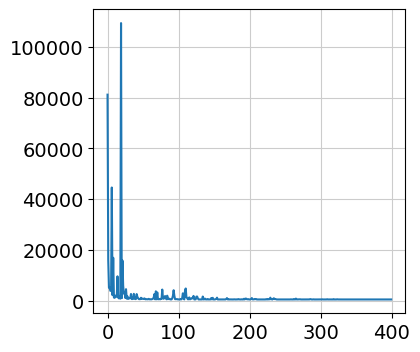

In [32]:
plt.plot(totalvae.history["elbo_validation"], label="test")

In [33]:
# To compare to the held-out data we also include the background component of expression
# This would be the mean of the negative binomial mixture


if not os.path.isfile('covid_imputedDual.csv'):
    _, protein_means = totalvae.get_normalized_expression(
        transform_batch=train_patients,
        include_protein_background=True,
        sample_protein_mixing=False,
        return_mean=True)
    
    protein_means.to_csv('covid_imputedDual.csv')
    
else:
    print("load")
    
    protein_means = pd.read_csv('covid_imputedDual.csv', index_col = 0)

load


In [34]:
X_totalVI = pd.DataFrame(totalvae.get_latent_representation(), index = adata_final.obs.index)
X_totalVI.to_csv("totalvi_covidintegrateembedding.csv")

# Imputed protein expression:

In [37]:
imputed_test1 = protein_means.loc[cells_train][proteins2]

pat_names = adata_final.obs['patient'].isin(train_patients)
patients = adata_final.obs.patient[pat_names].values
truth_test1 = pd.DataFrame(testset1_truth_[cells_train, proteins2].X.toarray(), index = testset1_truth_[cells_train].obs.index,
                           columns = testset1_truth_.var.index)# Subset totalvi output to only include overlapping proteins

In [38]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [39]:
# Normalize totalvi output, and gold standard counts

true_protein_test = truth_test1.copy()
true_protein_test = AnnData(true_protein_test.copy())
imputed_proteins_test = AnnData(imputed_test1.copy())

sc.pp.normalize_total(true_protein_test)
sc.pp.log1p(true_protein_test)

sc.pp.normalize_total(imputed_proteins_test)
sc.pp.log1p(imputed_proteins_test)

for patient in test_patients:
    indices = [x == patient for x in patients]
    sub_adata = imputed_proteins_test[indices]
    sc.pp.scale(sub_adata)
    imputed_proteins_test[indices] = sub_adata.X
    
    sub_adata = true_protein_test[indices]
    sc.pp.scale(sub_adata)
    true_protein_test[indices] = sub_adata.X

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: Mean of empty slice.
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


In [40]:
sq = lambda x, y: (x - y)**2

In [41]:
corrs_table = np.zeros((imputed_proteins_test.shape[1], len(np.unique(patients))))
sq_table = corrs_table.copy()

for i, patient in enumerate(np.unique(patients)):
    truth = true_protein_test[patients == patient].X
    imputed = imputed_proteins_test[patients == patient].X

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)

if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0
    
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)
corrs_table.index, corrs_table.columns = imputed_proteins_test.var.index, np.unique(patients)
sq_table.index, sq_table.columns = imputed_proteins_test.var.index, np.unique(patients)

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [43]:
#here are correlations

corrs_table.mean()

AP1              0.056374
AP10             0.055177
AP11             0.039170
AP12             0.092520
AP2              0.049647
                   ...   
newcastle21v2    0.081470
newcastle49      0.060218
newcastle59      0.072382
newcastle65      0.106288
newcastle74      0.107140
Length: 143, dtype: float64

In [44]:
corrs_table.mean().mean()

0.08809002472018182

In [45]:
corrs_table.to_csv('corrs_results/totalvi_covidintegratebig.csv')

In [46]:
sq_table.mean(axis = 0)

AP1              3.605315
AP10             3.676826
AP11             3.727594
AP12             3.613965
AP2              3.208691
                   ...   
newcastle21v2    4.115707
newcastle49      4.087601
newcastle59      3.940603
newcastle65      4.023078
newcastle74      3.964806
Length: 143, dtype: float64

In [47]:
sq_table.mean().mean()

3.6279559554291385

In [48]:
sq_table.to_csv('mse_results/totalvi_covidintegratebig.csv')

In [50]:
imputed_proteins_test = pd.DataFrame(imputed_proteins_test.X, index = imputed_proteins_test.obs.index, columns = imputed_proteins_test.var.index)
imputed_proteins_test.to_csv('totalvi_covidintegratebigfeatures.csv')

In [51]:
imputed_test2 = protein_means.loc[cells_test][proteins1]

pat_names = adata_final.obs['patient'].isin(test_patients)
patients = adata_final.obs.patient[pat_names].values
truth_test2 = pd.DataFrame(testset2_truth_[cells_test, proteins1].X.toarray(), index = testset2_truth_[cells_test].obs.index,
                           columns = testset2_truth_.var.index)# Subset totalvi output to only include overlapping proteins

In [52]:
# Normalize totalvi output, and gold standard counts

true_protein_test = truth_test2.copy()
true_protein_test = AnnData(true_protein_test.copy())
imputed_proteins_test = AnnData(imputed_test2.copy())

sc.pp.normalize_total(true_protein_test)
sc.pp.log1p(true_protein_test)

sc.pp.normalize_total(imputed_proteins_test)
sc.pp.log1p(imputed_proteins_test)

for patient in test_patients:
    indices = [x == patient for x in patients]
    sub_adata = imputed_proteins_test[indices]
    sc.pp.scale(sub_adata)
    imputed_proteins_test[indices] = sub_adata.X
    
    sub_adata = true_protein_test[indices]
    sc.pp.scale(sub_adata)
    true_protein_test[indices] = sub_adata.X

In [53]:
corrs_table = np.zeros((imputed_proteins_test.shape[1], len(np.unique(patients))))
sq_table = corrs_table.copy()

for i, patient in enumerate(np.unique(patients)):
    truth = true_protein_test[patients == patient].X
    imputed = imputed_proteins_test[patients == patient].X

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)
    
if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0
    
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)
corrs_table.index, corrs_table.columns = imputed_proteins_test.var.index, np.unique(patients)
sq_table.index, sq_table.columns = imputed_proteins_test.var.index, np.unique(patients)

In [55]:
#here are correlations

corrs_table.mean()

GWAS_1     0.321327
GWAS_10    0.250454
GWAS_11    0.320759
GWAS_12    0.318926
GWAS_13    0.319578
GWAS_2     0.386581
GWAS_3     0.438282
GWAS_4     0.262598
GWAS_5     0.303890
GWAS_8     0.335444
Unknown    0.259342
dtype: float64

In [56]:
corrs_table.mean().mean()

0.319743864346168

In [57]:
corrs_table.to_csv('corrs_results/totalvi_covidintegratesmall.csv')

In [58]:
sq_table.mean(axis = 0)

GWAS_1     1.357240
GWAS_10    1.499050
GWAS_11    1.358355
GWAS_12    1.362034
GWAS_13    1.360740
GWAS_2     1.226742
GWAS_3     1.123350
GWAS_4     1.474736
GWAS_5     1.392202
GWAS_8     1.329058
Unknown    1.481230
dtype: float64

In [59]:
sq_table.mean().mean()

1.360430715417979

In [60]:
sq_table.to_csv('mse_results/totalvi_covidintegratesmall.csv')

In [61]:
imputed_proteins_test = pd.DataFrame(imputed_proteins_test.X, index = imputed_proteins_test.obs.index, columns = imputed_proteins_test.var.index)
imputed_proteins_test.to_csv('totalvi_covidintegratesmallfeatures.csv')

In [62]:
corrs_table.to_csv('totalvi_covid.csv')